In [ ]:
!pip install transformers
!pip install pytorch-crf
!mkdir models
!mkdir pretrained_model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.4 MB/s 
     |████████████████████████████████| 7.6 MB 64.9 MB/s 
     |████████████████████████████████| 182 kB 69.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoModel, AutoTokenizer

embedding_model_name="athiban2001/cord-scibert"

bert = AutoModel.from_pretrained(embedding_model_name)
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name, use_fast=False)
bert.save_pretrained(f"./pretrained_model/cord-scibert")
tokenizer.save_pretrained("./pretrained_model/cord-scibert")


Downloading:   0%|          | 0.00/644 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at athiban2001/cord-scibert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at athiban2001/cord-scibert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.

Downloading:   0%|          | 0.00/359 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/264k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

('./pretrained_model/cord-scibert/tokenizer_config.json',
 './pretrained_model/cord-scibert/special_tokens_map.json',
 './pretrained_model/cord-scibert/vocab.txt',
 './pretrained_model/cord-scibert/added_tokens.json')

In [ ]:
import transformers

DEVICE = 'cuda'
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS =5
NUM_WORKER = 2
BASE_MODEL_PATH = "./pretrained_model/cord-scibert"
MODEL_PATH = "models/JNLPBA_covbert"
TRAINING_FILE = "../input/jnlpba"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=True
)


In [ ]:
import torch

class EntityDataset:
    def __init__(self, texts, tags,enc_tag):
        # texts: [["hi", ",", "my", "name", "is", "abhishek"], ["hello".....]]
        # pos/tags: [[1 2 3 4 1 5], [....].....]]
        self.texts = texts
        # self.pos = pos
        self.tags = tags
        self.enc_tag=enc_tag
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        # pos = self.pos[item]
        tags = self.tags[item]

        ids = []
        # target_pos = []
        target_tag =[]

        for i, s in enumerate(text):
            inputs = TOKENIZER.encode(
                str(s),
                add_special_tokens=False
            )
            # abhishek: ab ##hi ##sh ##ek
            input_len = len(inputs)
            ids.extend(inputs)
            # target_pos.extend([pos[i]] * input_len)
            target_tag.extend([tags[i]] * input_len)
        '''print("input:  ",inputs)
        print("ids  ",ids)'''
        ids = ids[:MAX_LEN - 2]
        # target_pos = target_pos[:MAX_LEN - 2]
        #print("ids  ",ids)
        target_tag = target_tag[:MAX_LEN - 2]
        #print("tag ",target_tag)

        ids = [102] + ids + [103]
        #print("ids  ",ids)
        # target_pos = [0] + target_pos + [0]
        o_tag=self.enc_tag.transform(["O"])[0]
        #print("o_tag ",o_tag)
        target_tag = [o_tag] + target_tag + [o_tag]
        #print("tag ",target_tag)

        mask = [1] * len(ids)
        #print(mask)
        token_type_ids = [0] * len(ids)
        #print(token_type_ids)
        padding_len = MAX_LEN - len(ids)
        #print(padding_len)
        ids = ids + ([0] * padding_len)
        #print(ids)
        mask = mask + ([0] * padding_len)
        #print(mask)
        token_type_ids = token_type_ids + ([0] * padding_len)
        # target_pos = target_pos + ([0] * padding_len)
        #print(token_type_ids)
        target_tag = target_tag + ([0] * padding_len)
        #print(target_tag)
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            # "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
            # "words":torch.tensor(words,dtype=torch.int)
        }


In [ ]:
import torch
import transformers
import torch.nn as nn
from torchcrf import CRF

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import joblib
import torch
import torch.utils.data

from sklearn import preprocessing
from sklearn import model_selection

total_tags=[]
with open("../content/drive/MyDrive/thesis/classes.txt") as f:
  for line in f.readlines():
    total_tags.append(line.strip())

enc_tag = preprocessing.LabelEncoder()
enc_tag.fit(list(total_tags))

def process_data(data_path):
    sentences,tags=[],[]
    sentence,tag=[],[]
    
    total_tags=set()
    i=0
    
    for path in data_path:
        with open(path,"r") as f:
            for line in f:
                if i%10000==0:
                  print(len(sentences))
                i+=1
                line=line.strip()
                if line.startswith("-DOCSTART-"):
                    continue
                elif len(line)==0:
                    if sentence==[] and tag==[]:
                        continue
                    sentences.append(sentence)
                    tags.append(tag)
                    sentence,tag=[],[]
                else:
                    s,t=line.split("\t")
                    sentence.append(s)
                    tag.append(t)

    for i in range(len(tags)):
        tags[i]=enc_tag.transform(tags[i])
                
    return sentences, tags, enc_tag


In [ ]:
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split("-",maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True
    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tags
    pred_seqs: a list of predicted tags
    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type
    correct_counts, true_counts, pred_counts: similar to above, but for tags
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    '''prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i tokens with %i phrases; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i phrases; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
        
    print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
    print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
    print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))'''

    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])
        res = (prec, rec, f1)

    return res
    # you can generate LaTeX output for tables like in
    # http://cnts.uia.ac.be/conll2003/ner/example.tex
    # but I'm not implementing this
def evaluate(true_seqs, pred_seqs, verbose=True):
    (correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
    result = get_result(correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts, verbose=verbose)
    return result


In [ ]:
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF
import math
from torch import Tensor
import numpy as np
from typing import Optional, Tuple


In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o


In [ ]:
class EntityModel(nn.Module):
    def __init__(self, num_tag):
        super(EntityModel,self).__init__()
        self.num_tag = num_tag

        #--------------------------BERT---------------------------------
        self.bert = transformers.BertModel.from_pretrained(BASE_MODEL_PATH,return_dict=False)
        self.clf_bert=nn.Linear(768,5)
        #------------------------------HA--BiLSTM-------------------------------------------
        self.gru = nn.GRU(768,20,1, batch_first=True, dropout=0.5) 
        self.attn = MultiheadAttention(20,20,10)
        self.lstm=nn.LSTM(20,5,1,batch_first=True,bidirectional=True)

        
        #------------------------------HMA--CNN---------------#
        self.conv1=nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding='valid', stride=1)
        self.batch_norm=nn.BatchNorm1d(256)
        self.conv2=nn.Conv1d(in_channels=768, out_channels=256, kernel_size=4, padding='valid', stride=1)
        #self.batch_norm=nn.BatchNorm1d(100)
        self.conv3=nn.Conv1d(in_channels=768, out_channels=256, kernel_size=5, padding='valid', stride=1)
        #self.batch_norm=nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.attncnn = MultiheadAttention(256,256,16)
        self.outcnn=nn.Linear(252,10)
        self.conv4= nn.Conv1d(in_channels=759, out_channels=256, kernel_size=5, padding='valid', stride=1)


        #--------------------CONVOLUTION BRANCH---------------------------------------------------------
        self.conv=nn.Conv1d(in_channels=768, out_channels=256, kernel_size=5, padding='valid', stride=1)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.dropout = nn.Dropout(0.3)

        #---------------DENSE LAYERS--------------------------------------------------------------------------------
        self.clf1 = nn.Linear(50,15)
        self.clf2 = nn.Linear(40,self.num_tag) 
        self.out=nn.Linear(10,5)
        self.out2=nn.Linear(20,5)
    

        #-----------------------------CRFLOSS-----------------------------------------------------
        self.crf_tag = CRF(self.num_tag, batch_first=True)
        
       
    
    # return the loss only, not encode the tag
    def forward(self, ids,mask, token_type_ids,target_tag):
        #--------------------BERT EMBEDDING----------------------------------
        y,_= self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)


        #--------------------BERT BRANCH------------------------------------
        z= self.dropout(y)
        z=self.clf_bert(y)
        z=z.permute(2,1,0)

        #----------------------CONVOLUTION BRANCH------------------------------
        x = y.permute(0,2,1)
        b=x
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.clf1(x)
        #x= self.clf2(x)
        x=x.permute(2,1,0)
        

        #--------------------GLOBAL+lOCAL-----------------------------------------------------------------------
        x=torch.cat([z,x],dim=0)
        #print(x.size())

        '''-----------------------------------------HA--- BILSTM-------------------------------------'''
        w,c=self.gru(y)
        #print(w.size())
        mask2=None
        attn_out = self.attn(w, mask=mask2)
        #print(attn_out.size())
        w,h=self.lstm(attn_out)
        #print(w.size())
        w=w.permute(2,1,0)

        '''-------------------------------------------------HMA---CNN-----------------------------------------------------'''
        a=self.conv1(b)
        #print(a.size())
        c=self.batch_norm(a)
        #print(c.size())
        d=self.relu(c)
        d=d.permute(2,0,1)
        
        e=self.conv2(b)
        #print(e.size())
        f=self.batch_norm(e)
        #print(f.size())
        g=self.relu(f)
        g=g.permute(2,0,1)

        h=self.conv3(b)
        #print(h.size())
        i=self.batch_norm(h)
        #print(i.size())
        j=self.relu(i)
        j=j.permute(2,0,1)
        
        #--------------------CONCATENING 3 CNN BRANCH---------------------------------------------------------------
        l=torch.cat([d,g,j])
        #print(l.size())
        attn_out1 = self.attncnn(l, mask=mask2)
        #print(attn_out1.size())
        attn_out1=attn_out1.permute(1,0,2)

        #------------------------------LAST CNN LAYER-------------------------------------------------------
        cnn=self.conv4(attn_out1)
        #print(cnn.size())
        cnn=self.outcnn(cnn)
        #print(cnn.size())
        cnn=cnn.permute(2,1,0)
        #----------------------------HA-BILSTM + HMA-CNN---------------------------------------------------------------------
        lstmcnn=torch.cat([w,cnn])
        #print(lstmcnn.size())

        #-----------------------------------HA-BILSTM + HMA-CNN+GLOBAL+LOCAL---------------------------------------------------
        final=torch.cat([lstmcnn,x])
        #print(final.size())
        final=final.permute(2,1,0)
        final=self.clf2(final)


        #------------------------CRF------------------------------------------------------------------
        mask1 = torch.where(mask==1, True, False)
        loss_tag = -self.crf_tag(final, target_tag, mask=mask1, reduction='token_mean')
        #print(loss_tag)
        loss=loss_tag
        return loss
        #return x

    #  encode the tag, dont return loss
    def encode(self, ids, mask, token_type_ids, target_tag):
        #--------------------BERT EMBEDDING----------------------------------
        y,_= self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)


        #--------------------BERT BRANCH------------------------------------
        z= self.dropout(y)
        z=self.clf_bert(y)
        z=z.permute(2,1,0)

        #----------------------CONVOLUTION BRANCH------------------------------
        x = y.permute(0,2,1)
        b=x
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.clf1(x)
        #x= self.clf2(x)
        x=x.permute(2,1,0)
        

        #--------------------GLOBAL+lOCAL-----------------------------------------------------------------------
        x=torch.cat([z,x],dim=0)
        #print(x.size())

        '''-----------------------------------------HA--- BILSTM-------------------------------------'''
        w,c=self.gru(y)
        #print(w.size())
        mask2=None
        attn_out = self.attn(w, mask=mask2)
        #print(attn_out.size())
        w,h=self.lstm(attn_out)
        #print(w.size())
        w=w.permute(2,1,0)

        '''-------------------------------------------------HMA---CNN-----------------------------------------------------'''
        a=self.conv1(b)
        #print(a.size())
        c=self.batch_norm(a)
        #print(c.size())
        d=self.relu(c)
        d=d.permute(2,0,1)
        
        e=self.conv2(b)
        #print(e.size())
        f=self.batch_norm(e)
        #print(f.size())
        g=self.relu(f)
        g=g.permute(2,0,1)

        h=self.conv3(b)
        #print(h.size())
        i=self.batch_norm(h)
        #print(i.size())
        j=self.relu(i)
        j=j.permute(2,0,1)
        
        #--------------------CONCATENING 3 CNN BRANCH---------------------------------------------------------------
        l=torch.cat([d,g,j])
        #print(l.size())
        attn_out1 = self.attncnn(l, mask=mask2)
        #print(attn_out1.size())
        attn_out1=attn_out1.permute(1,0,2)

        #------------------------------LAST CNN LAYER-------------------------------------------------------
        cnn=self.conv4(attn_out1)
        #print(cnn.size())
        cnn=self.outcnn(cnn)
        #print(cnn.size())
        cnn=cnn.permute(2,1,0)
        #----------------------------HA-BILSTM + HMA-CNN---------------------------------------------------------------------
        lstmcnn=torch.cat([w,cnn])
        #print(lstmcnn.size())

        #-----------------------------------HA-BILSTM + HMA-CNN+GLOBAL+LOCAL---------------------------------------------------
        final=torch.cat([lstmcnn,x])
        #print(final.size())
        final=final.permute(2,1,0)
        final=self.clf2(final)
        
        #---------------------------------CRF---------------------------------------------------------
        mask1 = torch.where(mask==1, True, False)
        tag = self.crf_tag.decode(final, mask=mask1)
        return tag


In [ ]:
class EntityModel1(nn.Module):
    def __init__(self, num_tag):
        super(EntityModel1, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.BertModel.from_pretrained(BASE_MODEL_PATH,return_dict=False)
        self.conv1=nn.Conv2d(768,256,kernel_size=16)
        self.conv2=nn.Conv2d(768,256,kernel_size=16)
        self.conv2_drop=nn.Dropout2d(0.5)
        self.fc1=nn.Linear(256,256)
        self.fc2=nn.Linear(256,5)
    def forward(self,ids,mask,token_type_ids,target_tag):
      y,_= self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
      print(y.size())
      x=F.relu(F.max_pool2d(self.conv1(y),2))
      print(x.size())
      x=x.permute(2,3,0,1)
      print(x.size())
      x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x),2)))
      print(x.size())
      '''x=x.view(-1,320)
      print(x.size())'''
      x=torch.cat(x,y)
      x=F.relu(self.fc1(x))
      print(x.size())
      #x=F.dropout(x,training=self.training)
      x=self.fc2(x)
      print(x.size())
      return F.log_softmax(x)


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
            #data[k] = torch.stack(data[k]).to(device)
        optimizer.zero_grad()
        loss= model(**data)
        #print(loss)
        #loss=output[0]
        loss.backward()
        optimizer.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0

    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        loss = model(**data)
        final_loss += loss.item()
    return final_loss / len(data_loader)

def load_model(epochs):
  path=MODEL_PATH+f"_{epochs}.bin"
  device = torch.device(DEVICE)
  model = EntityModel(num_tag=num_tag)
  model.load_state_dict(torch.load(path))
  model.to(device)
  return model

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
if __name__ == "__main__":
    sentences, tag, enc_tag = process_data(["../content/drive/MyDrive/thesis/train.tsv","../content/drive/MyDrive/thesis/devel.tsv"])
    test_sentences, test_tag, _ = process_data(["../content/drive/MyDrive/thesis/test.tsv"])

    meta_data = {
        "enc_tag": enc_tag
    }

    joblib.dump(meta_data, "meta.bin")

    num_tag = len(list(enc_tag.classes_))

    (
        train_sentences,
        valid_sentences,
        train_tag,
        valid_tag
    ) = model_selection.train_test_split(sentences, tag, random_state=42, test_size=0.1)

    train_dataset = EntityDataset(texts=train_sentences, tags=train_tag,enc_tag=enc_tag)

    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER)

    valid_dataset = EntityDataset(texts=valid_sentences, tags=valid_tag,enc_tag=enc_tag)

    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKER)

    test_dataset=EntityDataset(texts=test_sentences,tags=test_tag,enc_tag=enc_tag)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKER)
    #print(train_data_loader)
    '''with torch.no_grad():
      outputs = model1(a,b)
      hidden_states = outputs[2]
      print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
      layer_i = 0
      print ("Number of batches:", len(hidden_states[layer_i]))
      batch_i = 0
      print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
      token_i = 0
      print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))
      print('Tensor shape for each layer: ', hidden_states[0].size())
      token_embeddings = torch.stack(hidden_states, dim=0)

      #len(token_embeddings)
      token_embeddings = torch.squeeze(token_embeddings, dim=1)

      #token_embeddings.size()
      token_embeddings = token_embeddings.permute(1,0,2)
      #token_embeddings.size()'''



    device = torch.device(DEVICE)
    model = EntityModel(num_tag=num_tag)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    

    #optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


0
385
766
1146
1532
1907
2300
2690
3083
3459
3839
4249
4631
5007
5383
5765
6125
0
370
734


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
sum(p.numel() for p in model.parameters())

115296868

In [ ]:
'''from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)'''

'from prettytable import PrettyTable\ndef count_parameters(model):\n    table = PrettyTable(["Modules", "Parameters"])\n    total_params = 0\n    for name, parameter in model.named_parameters():\n        if not parameter.requires_grad: continue\n        params = parameter.numel()\n        table.add_row([name, params])\n        total_params+=params\n    print(table)\n    print(f"Total Trainable Params: {total_params}")\n    return total_params\n    \ncount_parameters(model)'

In [ ]:
tr_loss=[]
val_loss=[]


In [ ]:
from prettytable import PrettyTable

#data={}
#df_list=[]
epochlist=[]
table = PrettyTable(["EPOCH", "Train_loss","Validation_Loss"])
for epoch in range(EPOCHS):
    epochlist.append(epoch)
    train_loss = train_fn(train_data_loader, model, optimizer, device)
    tr_loss.append(train_loss)
    torch.cuda.empty_cache()
    valid_loss = eval_fn(valid_data_loader, model, device)
    val_loss.append(valid_loss)
    table.add_row([epoch,train_loss,valid_loss])
    #data[epoch] = [(epoch,train_loss,valid_loss)]
    #df = pd.DataFrame(data, columns =['Name', 'Age', 'Score'])
    torch.cuda.empty_cache()
    print(f"Train Loss = {train_loss}")
    print(f"Validation Loss = {valid_loss}")
    #test_fn(test_dataset, model, device,enc_tag)
    torch.save(model.state_dict(), MODEL_PATH+f"_{epoch}.bin")
dict={"Epoch":epochlist,"train_loss":tr_loss,"valid_loss":val_loss}
df=pd.DataFrame(dict)

100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss = 0.38668427585052845
Validation Loss = 0.34344472438097


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Loss = 0.3098489352468015
Validation Loss = 0.32635543681681156


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Loss = 0.2860149751190378
Validation Loss = 0.3099606156349182


100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


Train Loss = 0.27230790188583004
Validation Loss = 0.30022637620568277


100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Train Loss = 0.2632014398105672
Validation Loss = 0.2892161224037409


In [ ]:
from google.colab import files
df.to_csv("abc.csv",header=False,index=False)
files.download('abc.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(table)

+-------+---------------------+---------------------+
| EPOCH |      Train_loss     |   Validation_Loss   |
+-------+---------------------+---------------------+
|   0   | 0.38668427585052845 |   0.34344472438097  |
|   1   |  0.3098489352468015 | 0.32635543681681156 |
|   2   |  0.2860149751190378 |  0.3099606156349182 |
|   3   | 0.27230790188583004 | 0.30022637620568277 |
|   4   |  0.2632014398105672 |  0.2892161224037409 |
+-------+---------------------+---------------------+


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

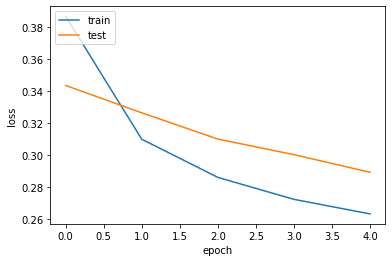

In [ ]:
g=plt.figure(3)
plt.plot(tr_loss)
plt.plot(val_loss)
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
g.savefig("lossvsepoch.pdf")
files.download("lossvsepoch.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve,roc_curve, auc
import torch.nn.functional as F


In [ ]:
def test_fn(dataset,model,device,enc_tag):
  final_test = []
  final_pred = []
  O=enc_tag.transform(["O"])[0]
  #y_prob=[]
  with torch.no_grad():
    for data in tqdm(dataset):
      for k, v in data.items():
          data[k] = v.to(device).unsqueeze(0)
      #label_id=label_id.to(device)
      '''logits,_= model(**data)
      logits = F.softmax(logits,dim=1)
      a=logits.cpu().numpy()
      y_prob.append(a)
      y_prob = np.concatenate(y_prob)
      labels=data["target_tag"].cpu()
      #probs =torch.softmax(logits, dim=1) # assuming logits has the shape [batch_size, nb_classes]
      #preds =torch.argmax(logits, dim=1)'''
      tag = model.encode(**data)
      #yhat = model.predict_proba(**data)
      padded_pred=tag[0]
      test=data["target_tag"].cpu()[0][:len(padded_pred)]
      test=enc_tag.inverse_transform(test)
      padded_pred=enc_tag.inverse_transform(padded_pred)
      final_pred.extend(padded_pred[1:-1])
      final_test.extend(test[1:-1])
        
    return final_pred,final_test
  #print(multilabel_confusion_matrix(final_test, final_pred))
  #print(classification_report(final_test, final_pred))
  #Roc_curve(final_test, final_pred)
  

In [ ]:
torch.cuda.empty_cache()
#test_fn(test_dataset, model, device,enc_tag)

In [ ]:
pred,y_test=test_fn(test_dataset, model, device,enc_tag)

100%|██████████| 939/939 [01:05<00:00, 14.30it/s]


In [ ]:
y_true=[]
y_pred=[]
tag2idx={
    "B-Disease":0,
    "E-Disease":1,
    "I-Disease":2,
    "S-Disease":3,
    "O":4
}
for i in range(0,len(y_test)):
  y_true.append(tag2idx[y_test[i]])
  y_pred.append(tag2idx[pred[i]])


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       759
           1       0.00      0.00      0.00       729
           2       0.00      0.00      0.00       718
           3       0.00      0.00      0.00       745
           4       0.89      1.00      0.94     24955

    accuracy                           0.89     27906
   macro avg       0.18      0.20      0.19     27906
weighted avg       0.80      0.89      0.84     27906



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
# 5 classes to classify
n_classes = 5

#X, y = make_classification(n_samples=80000, n_features=20, n_informative=3, n_redundant=0, n_classes=n_classes,n_clusters_per_class=2)
# Binarize the output
y_true= label_binarize(y_true, classes=[0,1,2,3,4])
y_pred= label_binarize(y_pred, classes= [0,1,2,3,4])
n_classes = y_true.shape[1]
print(y_true)
print(n_classes)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

[[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]]
5


<ipython-input-46-a8208989a224>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_recall += interp(all_precision, precision["micro"], recall["micro"])


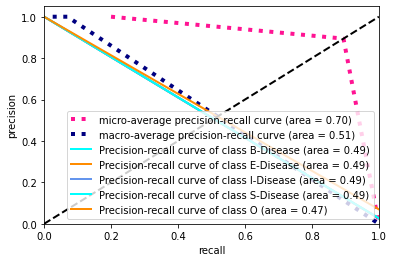

In [ ]:
import numpy as np
from scipy import interp
from itertools import cycle
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
precision = defaultdict()
recall = defaultdict()
pre_auc = defaultdict()
for i in range(n_classes):
    precision[i],recall[i], _ = precision_recall_curve(y_true[:, i],y_pred[:,i])
    pre_auc[i] = auc(precision[i],recall[i])
precision[4][0]= 0.0697845
'''precision[4][1]= 0.95792325
precision[4][2]= 1.
recall[4][0]= 1.
recall[4][1]= 0.70244841
recall[4][2]= 0.'''
pre_auc[i] = auc(precision[i],recall[i])
# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
pre_auc["micro"] = auc(precision["micro"], recall["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_recall= np.zeros_like(all_precision)
for i in range(n_classes):
    mean_recall += interp(all_precision, precision["micro"], recall["micro"])

# Finally average it and compute AUC
mean_recall/= n_classes

precision["macro"] = all_precision
recall["macro"] = mean_recall
pre_auc["macro"] = auc(precision["macro"], recall["macro"])
l=["B-Disease","E-Disease","I-Disease","S-Disease","O"]

# Plot all ROC curves
h=plt.figure(1)
plt.plot(precision["micro"], recall["micro"],
         label='micro-average precision-recall curve (area = {0:0.2f})'
               ''.format(pre_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(precision["macro"], recall["macro"],
         label='macro-average precision-recall curve (area = {0:0.2f})'
               ''.format(pre_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i],precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], pre_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('precision')
plt.xlabel('recall')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
for i in range(n_classes):
  print(precision[i])
  print(recall[i])

[0.02719845 1.        ]
[1. 0.]
[0.02612341 1.        ]
[1. 0.]
[0.02572923 1.        ]
[1. 0.]
[0.02669677 1.        ]
[1. 0.]
[0.0697845 1.       ]
[1. 0.]


In [ ]:
h.savefig("precrecall.pdf", bbox_inches='tight')
files.download("precrecall.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-49-96dcc0c72829>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


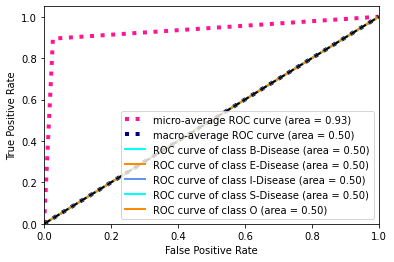

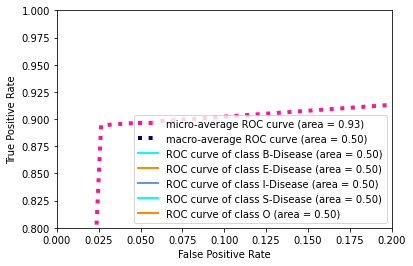

In [ ]:
import numpy as np
from scipy import interp
from itertools import cycle
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = defaultdict()
tpr = defaultdict()
roc_auc = defaultdict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
l=["B-Disease","E-Disease","I-Disease","S-Disease","O"]

# Plot all ROC curves
f=plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
f.savefig("ROC.pdf", bbox_inches='tight')
files.download("ROC.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(n_classes):
  print(fpr[i])
  print(tpr[i])

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
